In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from architectures.fc_models import binary_out

2024-04-01 19:50:34.610115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 19:50:34.720300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 19:50:34.720410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 19:50:34.737174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 19:50:34.786276: I tensorflow/core/platform/cpu_feature_guar

In [2]:
PATCH_SIZE = 8
BINARY_SIZE = 4
STEPS = 16

In [3]:
def get_data():
    from keras.datasets import cifar10

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = tf.image.extract_patches(x_train, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')
    x_train = tf.reshape(x_train, [-1, PATCH_SIZE, PATCH_SIZE, 3])
    x_train = tf.divide(tf.cast(x_train, tf.float32), 127.5) - 1

    return x_train

In [4]:
def l2_loss(y_true, y_pred):
    # normalize the loss by the number of pixels
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

In [5]:
def resBlock(inputs, binary_size, step):
    inputs = tf.reshape(inputs, [-1, PATCH_SIZE * PATCH_SIZE * 3])
    x = tf.keras.layers.Dense(512, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(512, activation='tanh')(x)
    x = tf.keras.layers.Dense(512, activation='tanh')(x)
    x = tf.keras.layers.Dense(binary_size, activation=binary_out, use_bias=False, trainable=True)(x)
    
    x = tf.keras.layers.Dense(512, activation='tanh')(x)
    x = tf.keras.layers.Dense(512, activation='tanh')(x)
    x = tf.keras.layers.Dense(512, activation='tanh')(x)
    x = tf.keras.layers.Dense(PATCH_SIZE*PATCH_SIZE*3, activation='tanh', name=f'output{step}')(x)
    x = tf.reshape(x, [-1, PATCH_SIZE, PATCH_SIZE, 3])

    return x

In [6]:
class ResidualModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def predict_step(self, data):
        # iterate through the layers and get the output of each layer
        x = data
        for layer in self.layers:
            print(layer.name)
            x = layer(x)
        return x


In [7]:
def make_model(patch_size, binary_size, iterations):
    x = x_new = input_layer = tf.keras.layers.Input(shape=(patch_size, patch_size, 3))
    encoders, decoders = [], []
    # add the residual blocks
    for i in range(iterations):
        x_current = x_new
        x_new = resBlock(x_new, binary_size, i)

        if i != iterations - 1:
            x_new = tf.keras.layers.Add()([x_current, -x_new])
        
    x = tf.reshape(x_new, [-1, PATCH_SIZE, PATCH_SIZE, 3])

    model = ResidualModel(inputs=input_layer, outputs=x)
    return model, encoders, decoders

In [8]:
network, encoders, decoders = make_model(PATCH_SIZE, BINARY_SIZE, STEPS)

2024-04-01 19:50:37.842671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 19:50:38.061617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 19:50:38.062289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 19:50:38.067893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 19:50:38.068258: I external/local_xla/xla/stream_executor

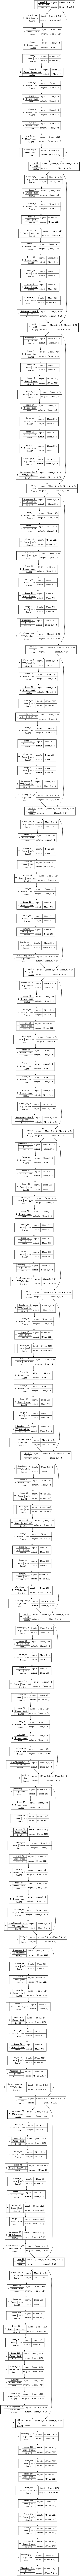

In [9]:
tf.keras.utils.plot_model(network, show_shapes=True, dpi=64, expand_nested=True, show_layer_activations=True, show_trainable=True, show_dtype=True, rankdir='TB', to_file='residual_model.png')

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
network.compile(optimizer=optimizer, loss='mse')
x_train = get_data()

In [11]:
x_train = x_train[:32000]

In [12]:
network.summary()

Model: "residual_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 3)]            0         []                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 192)                  0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 512)                  98816     ['tf.reshape[0][0]']          
                                                                                                  
 dense_1 (Dense)             (None, 512)                  262656    ['dense[0][0]']               
                                                                                     

In [13]:
network.fit(x_train, x_train, epochs=1)

2024-04-01 19:50:53.689407: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-01 19:50:54.207606: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe67e0df110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-01 19:50:54.207663: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-04-01 19:50:54.229847: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-01 19:50:54.269575: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1711990254.375915   98834 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 62s 38ms/step - loss: 1.6870


In [24]:
random_image = x_train[0]

x = random_image
for layer in network.layers:
    print(layer.name)
    x = layer(x)
    

input_1
tf.reshape


TypeError: Missing required positional argument

In [ ]:
x_sample = x_train[0:16]
x_pred = network.predict(x_sample)

fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow((x_pred[i*4+j] + 1) / 2)
plt.show()